# 2023-10-25 Multigrid

## Last time

* Preconditioning building blocks
* Domain decomposition
* PETSc discussion

## Today
* Software licensing
* Projects
* Multigrid
  * Spectral perspective
  * Factorization perspective


In [1]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

function advdiff_matrix(n; kappa=1, wind=[0, 0])
    h = 2 / (n + 1)
    rows = Vector{Int64}()
    cols = Vector{Int64}()
    vals = Vector{Float64}()
    idx((i, j),) = (i-1)*n + j
    in_domain((i, j),) = 1 <= i <= n && 1 <= j <= n
    stencil_advect = [-wind[1], -wind[2], 0, wind[1], wind[2]] / h
    stencil_diffuse = [-1, -1, 4, -1, -1] * kappa / h^2
    stencil = stencil_advect + stencil_diffuse
    for i in 1:n
        for j in 1:n
            neighbors = [(i-1, j), (i, j-1), (i, j), (i+1, j), (i, j+1)]
            mask = in_domain.(neighbors)
            append!(rows, idx.(repeat([(i,j)], 5))[mask])
            append!(cols, idx.(neighbors)[mask])
            append!(vals, stencil[mask])
        end
    end
    sparse(rows, cols, vals)
end

advdiff_matrix (generic function with 1 method)

# Licensing and Copyright

* In the US, all creative works are subject to copyright. This includes code.
* At CU, you own copyright for anything you create in coursework or on your own time.
* CU asserts copyright on work you while employed (e.g., as a GRA)
  * My group has an exemption letter that applies in some cases.
* **No permissions** are granted by default, even if you post your code publicly on GitHub.

<blockquote class="twitter-tweet"><p lang="en" dir="ltr"><a href="https://twitter.com/github?ref_src=twsrc%5Etfw">@github</a> copilot, with &quot;public code&quot; blocked, emits large chunks of my copyrighted code, with no attribution, no LGPL license. For example, the simple prompt &quot;sparse matrix transpose, cs_&quot; produces my cs_transpose in CSparse. My code on left, github on right. Not OK. <a href="https://t.co/sqpOThi8nf">pic.twitter.com/sqpOThi8nf</a></p>&mdash; Tim Davis (@DocSparse) <a href="https://twitter.com/DocSparse/status/1581461734665367554?ref_src=twsrc%5Etfw">October 16, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

Almost all licenses require these conditions (from BSD-2-Clause)
1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

# License compatibility

<img src="https://dwheeler.com/essays/floss-license-slide-image.png" width="100%" />

[CC BY-SA-3.0](https://creativecommons.org/licenses/by-sa/3.0/) [David A. Wheeler](https://dwheeler.com/essays/floss-license-slide.html)

## Recommendation

Use the most standard license that meets your needs.

License proliferation saps time and discourages users. See [OSI recommendations](https://opensource.org/licenses/category) and [Todd Gamblin's recommendations for LLNL](https://www.osti.gov/servlets/purl/1782513/)

* [SPDX License names](https://spdx.org/licenses/)

* Permissive (MIT, BSD, Apache-2.0)
  * Can put into proprietary software, as a library or with customization.
  * Can't plagiarize (attribution required)
* Weak Copyleft (LGPL, MPL)
  * Can use as a *dynamically linked* library in proprietary products
    * Must be able to link modifications of library.
  * Modifications are subject to LGPL (anyone who has the product can have the code, modify, redistribute)
* Strong Copyleft (GPL, AGPL)
  * "viral" -- anyone who has/uses the software product can access the source code, modify, and redistribute.

# Software patents and inbound=outbound

* Patent litigation is hugely destructive for open source communities.
* There is no legal consensus about whether making a contribution implies a grant to any patents that may be infringed by that contribution.
* Apache-2.0 $\approx$ MIT/BSD plus patent grant and indemnification

## Problem
GPL/LGPL forbid adding new restrictions. The Free Software Foundation believes the Apache-2.0 indemnification clause violates GPL/LGPL.
## Solutions
* `(Apache-2.0 OR MIT)` (Rust Language)
* `Apache-2.0 WITH LLVM-exception`

# Contributor License Agreements

* [Apache-2.0 CLA](https://www.apache.org/licenses/contributor-agreements.html): paper signed documents granting terms of Apache-2.0 license.
  * One per person or organization (signed by employer/counsel)
  * Creates friction to contribute, bookkeeping for maintainers, coarse granularity.
* [Developers Certificate of Origin](https://developercertificate.org/)
  * Developed for the Linux Kernel in wake of SCO lawsuits.
  * Low-friction for contributors, fine granularity with low bookkeeping.\
  * Confirms authority to contribute and **inbound=outbound**

# Searching for projects

## [GitHub codesearch](https://github.com/search)

* Check Insights -> Contributors
  * Sustained versus short-term activity
  * Number of stakeholders
  * `git shortlog -se --since=2016 | sort -n`
* Community signals
  * Code of Conduct
  * Contributing guidelines, pull request templates
  * Active review and mentoring in pull requests
* Continuous integration
  * Actions tab, also report in pull requests
  * Pipelines for repositories on GitLab

## Journals

### [Journal of Open Source Software](https://joss.theoj.org/papers)

* Papers on mature software with many users
* Immature research software with a few users, but best practices and intent to grow

### [Geoscientific Model Development](https://geoscientific-model-development.net/)

* Blends software and methods work

# PETSc experiments

* Compare domain decomposition and multigrid preconditioning
 * `-pc_type asm` (Additive Schwarz)
  * `-pc_asm_type basic` (symmetric, versus `restrict`)
  * `-pc_asm_overlap 2` (increase overlap)
  * Effect of direct subdomain solver: `-sub_pc_type lu`

* Symmetric example: `src/snes/examples/tutorials/ex5.c`
* Nonsymmetric example: `src/snes/examples/tutorials/ex19.c`
* Compare preconditioned versus unpreconditioned norms.
* Compare BiCG versus GMRES
 * `-pc_type mg` (Geometric Multigrid)
* Use monitors:
 * `-ksp_monitor_true_residual`
 * `-ksp_monitor_singular_value`
 * `-ksp_converged_reason`
* Explain methods: `-snes_view`
* Performance info: `-log_view`

# Geometric multigrid and the spectrum

Multigrid uses a hierarchy of scales to produce an operation "$M^{-1}$" that can be applied in $O(n)$ ("linear") time and such that $\lVert I - M^{-1} A \rVert \le \rho < 1$ independent of the problem size.
We'll consider the one dimensional Laplacian using the stencil
$$ \Big(\frac{h^2}{2}\Big) \frac{1}{h^2} \begin{bmatrix} -1 & 2 & -1 \end{bmatrix} $$

In [26]:
function laplace1d(n)
    "1D Laplacion with Dirichlet boundary conditions eliminated"
    h = 2 / (n + 1)
    x = LinRange(-1, 1, n+2)[2:end-1]
    A = diagm(0 => ones(n),
        -1 => -.5*ones(n-1),
        +1 => -.5*ones(n-1))
    x, A # Hermitian(A)
end

laplace1d (generic function with 1 method)

L[1:2] = [0.00048371770801235576, 0.0019344028664056293]
L[end - 1:end] = [1.9980655971335943, 1.999516282291988]


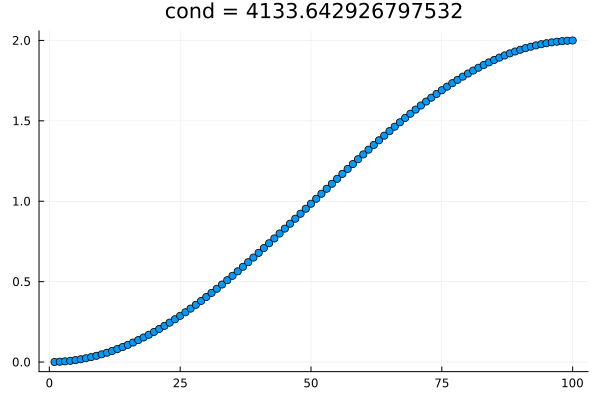

In [30]:
x, A = laplace1d(100)
#@show A[1:4,1:4]
L, X = eigen(A)
@show L[1:2]
@show L[end-1:end]
scatter(L, title="cond = $(L[end]/L[1])", legend=:none)

# What do the eigenvectors look like?

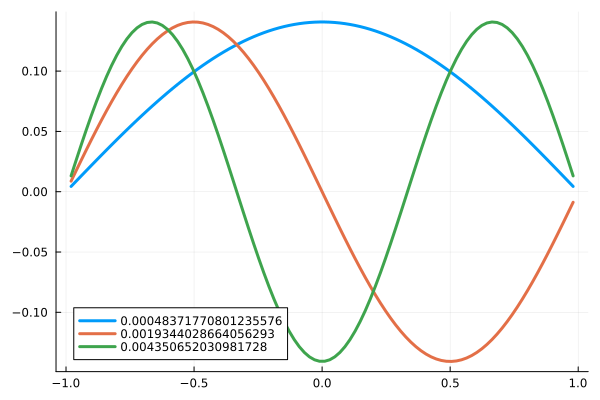

In [4]:
x, A = laplace1d(100)
L, X = eigen(A)
plot(x, X[:,1:3], label=L[1:3]', legend=:bottomleft)

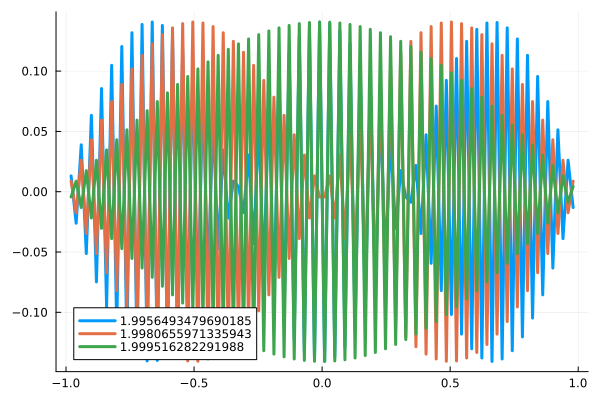

In [5]:
plot(x, X[:, end-2:end], label=L[end-2:end]', legend=:bottomleft)

# Condition number grows with grid refinement

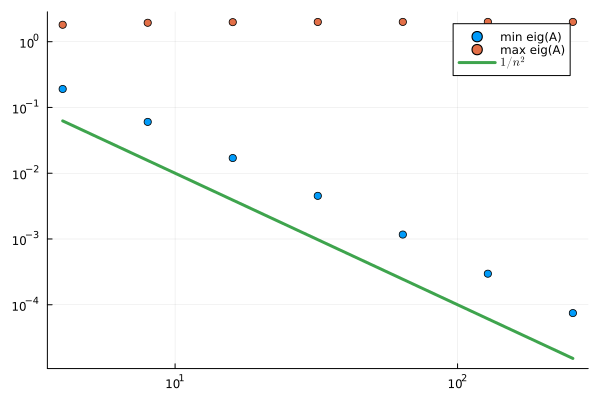

In [6]:
ns = 2 .^ (2:8)
eigs = vcat([eigvals(laplace1d(n)[2])[[1, end]] for n in ns]'...)

scatter(ns, eigs, label=["min eig(A)" "max eig(A)"])
plot!(n -> 1/n^2, label="\$1/n^2\$", xscale=:log10, yscale=:log10)

# Fourier analysis perspective

Consider the basis $\phi(x, \theta) = e^{i \theta x}$.  If we choose the grid $x \in h \mathbb Z$ with grid size $h$ then we can resolve frequencies $\lvert \theta \rvert \le \pi/h$.

In [7]:
function symbol(S, theta)
    if length(S) % 2 != 1
        error("Length of stencil must be odd")
    end
    w = length(S) ÷ 2
    phi = exp.(1im * (-w:w) * theta')
    vec(S * phi) # not! (S * phi)'
end

function plot_symbol(S, deriv=2; plot_ref=true, n_theta=30)
    theta = LinRange(-pi, pi, n_theta)
    sym = symbol(S, theta)
    rsym = real.((-1im)^deriv * sym)
    fig = plot(theta, rsym, marker=:circle, label="stencil")
    if plot_ref
        plot!(fig, th -> th^deriv, label="exact")
    end
    fig
end

plot_symbol (generic function with 2 methods)

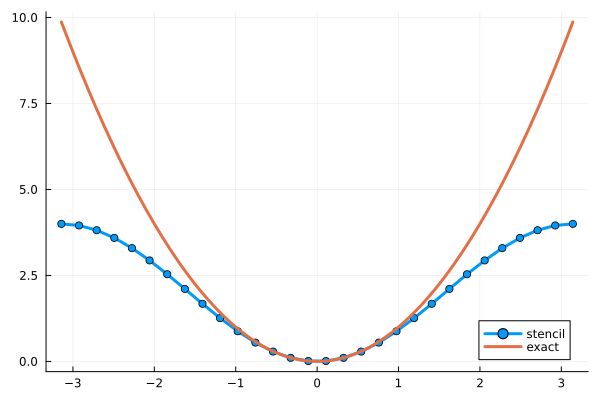

In [8]:
plot_symbol([1 -2 1])
#plot!(xlims=(-1, 1))

# Analytically computing smallest eigenvalue

The longest wavelength for a domain size of 2 with Dirichlet boundary conditions is 4. The frequency is $\theta = 2\pi/\lambda = \pi/2$. The `symbol` function works on an integer grid. We can transform via $\theta \mapsto \theta h$.

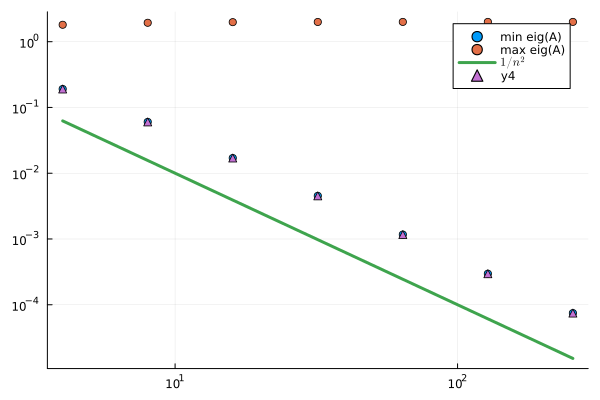

In [9]:
scatter(ns, eigs, label=["min eig(A)" "max eig(A)"])
plot!(n -> 1/n^2, label="\$1/n^2\$", xscale=:log10, yscale=:log10)
theta_min = pi ./ (ns .+ 1)
symbol_min = -real(symbol([1 -2 1], theta_min))
scatter!(ns, symbol_min / 2, shape=:utriangle)

# Damping properties of Richardson/Jacobi relaxation

Recall that we would like for $I - w A$ to have a small norm, such that powers (repeat iterations) will cause the error to decay rapidly.

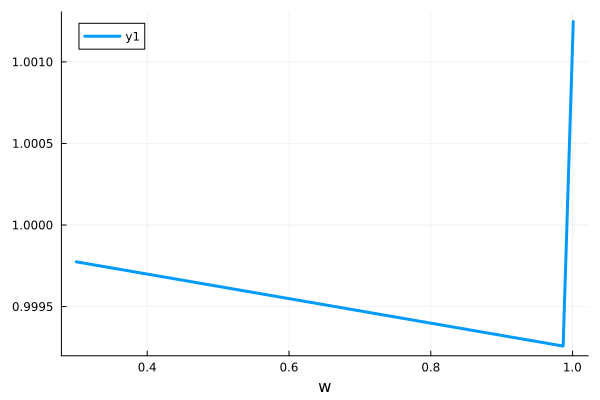

In [34]:
x, A = laplace1d(80)
ws = LinRange(.3, 1.001, 50)
radius = [opnorm(I - w*A) for w in ws]
plot(ws, radius, xlabel="w")

* The spectrum of $A$ runs from $\theta_{\min}^2$ up to 2.  If $w > 1$, then $\lVert I - w A \rVert > 1$ because the operation amplifies the high frequencies (associated with the eigenvalue of 2).
* The value of $w$ that minimizes the norm is slightly less than 1, but the convergence rate is very slow (only barely less than 1).

# Symbol of damping

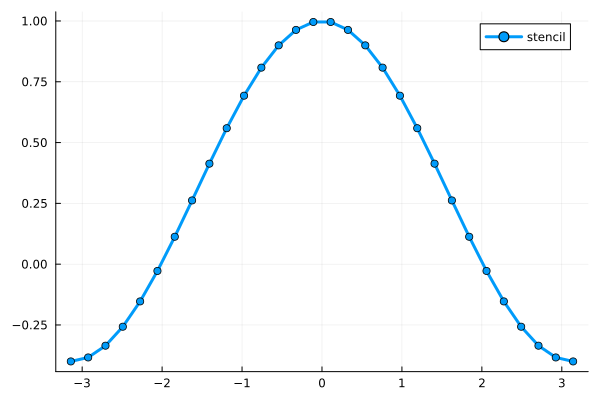

In [35]:
w = .7
plot_symbol([0 1 0] - w * [-.5 1 -.5], 0; plot_ref=false)

* Evidently it is very difficult to damp low frequencies.
* This makes sense because $A$ and $I - wA$ move information only one grid point per iteration.
* It also makes sense because the polynomial needs to be 1 at the origin, and the low frequencies have eigenvalues very close to zero.

# Coarse grids: Make low frequencies high (again)

As in domain decomposition, we will express our "coarse" subspace, consisting of a grid $x \in 2h\mathbb Z$, in terms of its interpolation to the fine space.  Here, we'll use linear interpolation.

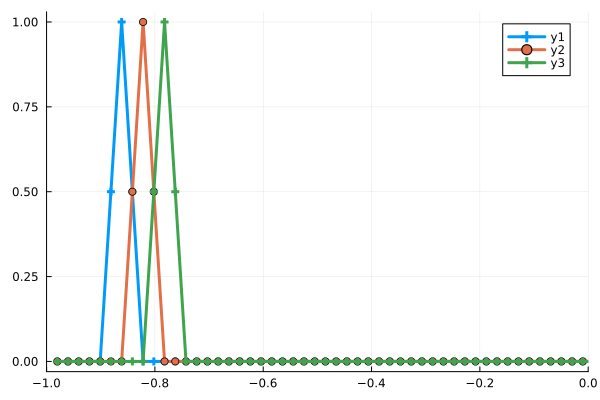

In [50]:
function interpolate(m, stride=2)
    s1 = (stride - 1) / stride
    s2 = (stride - 2) / stride
    P = diagm(0 => ones(m),
        -1 => s1*ones(m-1), +1 => s1*ones(m-1),
        -2 => s2*ones(m-2), +2 => s2*ones(m-2))
    P[:, 1:stride:end]
end
n = 100; x, A = laplace1d(n)
P = interpolate(n, 2)
plot(x, P[:, 4:6], marker=:auto, xlims=(-1, 0))

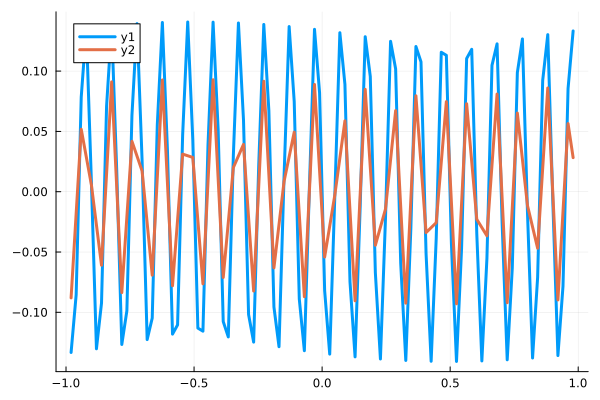

In [51]:
L, X = eigen(A)
u_h = X[:, 40]
u_2h = .5 * P' * u_h
plot(x, [u_h, P * u_2h])

# Galerkin approximation of $A$ in coarse space

$$ A_{2h} u_{2h} = P^T A_h P u_{2h} $$

size(A) = (100, 100)
size(A_2h) = (50, 50)


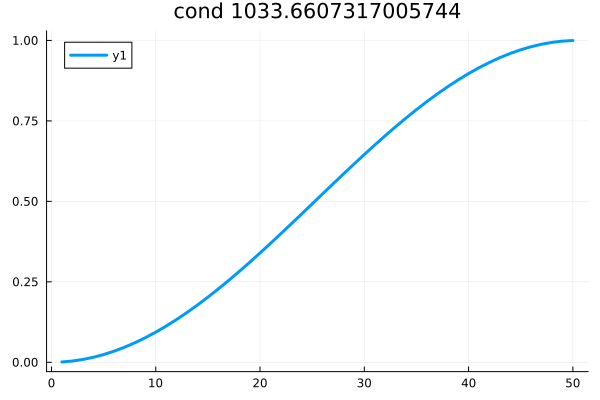

In [52]:
x, A = laplace1d(n)
P = interpolate(n)
@show size(A)
A_2h = P' * A * P
@show size(A_2h)
L_2h = eigvals(A_2h)
plot(L_2h, title="cond $(L_2h[end]/L_2h[1])")

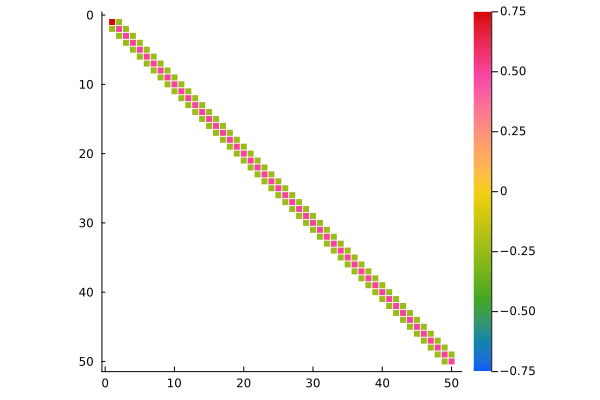

In [53]:
my_spy(A_2h)

# Coarse grid correction

Consider the $A$-orthogonal projection onto the range of $P$,
$$ S_c = P A_{2h}^{-1} P^T A $$

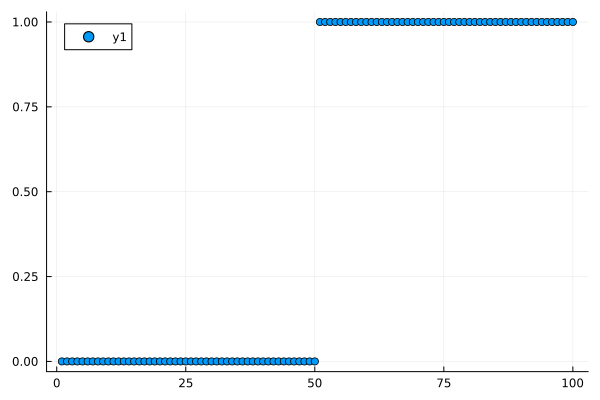

In [54]:
Sc = P * (A_2h \ P' * A)
Ls, Xs = eigen(I - Sc)
scatter(real.(Ls))

* This spectrum is typical for a projector. If $u$ is in the range of $P$, then $S_c u = u$. Why?
* For all vectors $v$ that are $A$-orthogonal to the range of $P$, we know that $S_c v = 0$. Why?

# A two-grid method

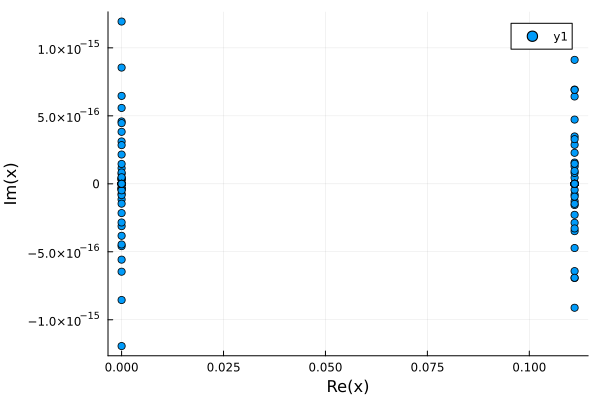

In [60]:
w = 2/3
T = (I - w*A) * (I - Sc) * (I - w*A)
Lt = eigvals(T)
scatter(Lt)

* Can analyze these methods in terms of frequency.
* [LFAToolkit](https://jeremylt.github.io/LFAToolkit.jl/stable/examples/diffusion/#Diffusion-operator)

# Multigrid as factorization

We can interpret factorization as a particular multigrid or domain decomposition method.

We can partition an SPD matrix as
$$A = \begin{bmatrix} F & B^T \\ B & D \end{bmatrix}$$
and define the preconditioner by the factorization
$$      M = \begin{bmatrix} I & \\ B F^{-1} & I \end{bmatrix}
      \begin{bmatrix} F &  \\ & S \end{bmatrix}
      \begin{bmatrix} I & F^{-1}B^T \\  & I \end{bmatrix}
$$
where $S = D - B F^{-1} B^T$.  $M$ has an inverse
$$
      \begin{bmatrix} I & -F^{-1}B^T \\  & I \end{bmatrix}
      \begin{bmatrix} F^{-1} &  \\ & S^{-1} \end{bmatrix}
      \begin{bmatrix} I & \\ -B F^{-1} & I \end{bmatrix} .
$$

Define the interpolation
$$ P_f = \begin{bmatrix} I \\ 0 \end{bmatrix}, \quad P_c = \begin{bmatrix} -F^{-1} B^T \\ I \end{bmatrix} $$ and rewrite as
$$ M^{-1} = [P_f\  P_c] \begin{bmatrix} F^{-1} P_f^T \\ S^{-1} P_c^T \end{bmatrix} = P_f F^{-1} P_f^T + P_c S^{-1} P_c^T.$$
The iteration matrix is thus
$$ I - M^{-1} A = I - P_f F^{-1} P_f^T J - P_c S^{-1} P_c^T A .$$

# Permute into C-F split

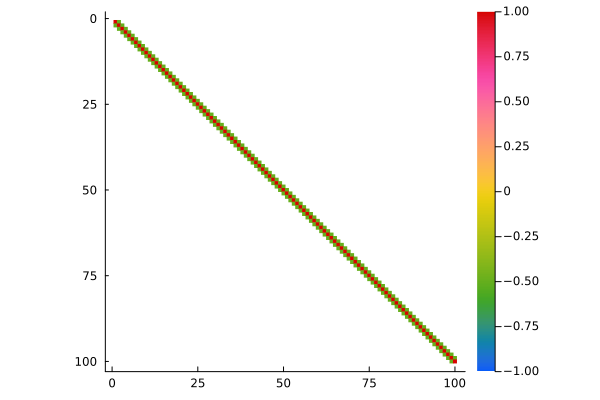

In [18]:
m = 100
x, A = laplace1d(m)
my_spy(A)

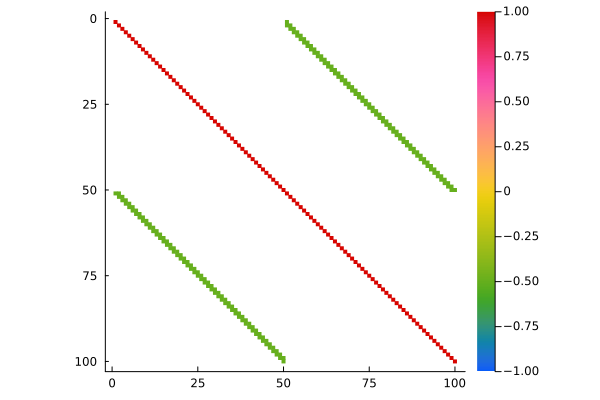

In [19]:
idx = vcat(1:2:m, 2:2:m)
J = A[idx, idx]
my_spy(J)

# Coarse basis functions

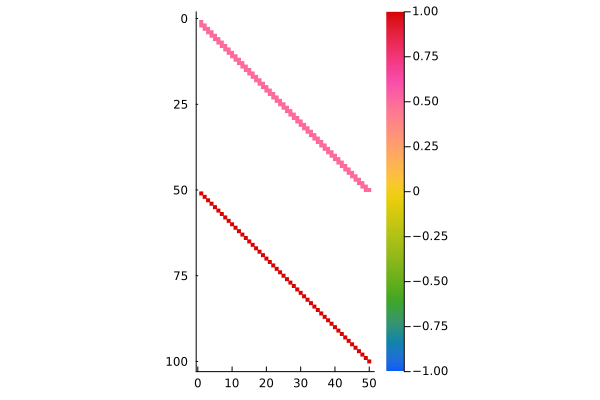

In [20]:
F = J[1:end÷2, 1:end÷2]
B = J[end÷2+1:end,1:end÷2]
P = [-F\B'; I]
my_spy(P)

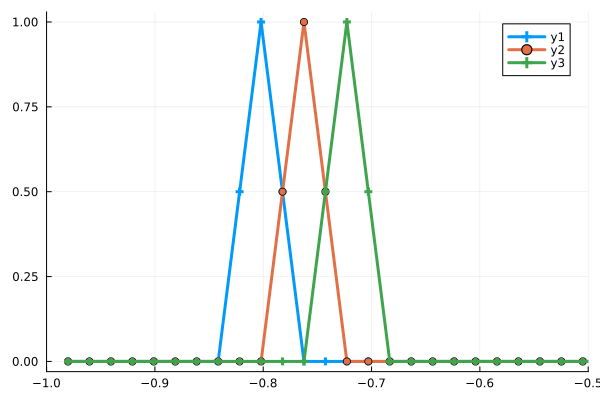

In [21]:
idxinv = zeros(Int64, m)
idxinv[idx] = 1:m
Pp = P[idxinv, :]
plot(x, Pp[:, 5:7], marker=:auto, xlims=(-1, -.5))

# From factorization to algebraic multigrid

* Factorization as a multigrid (or domain decomposition) method incurs significant cost in multiple dimensions due to lack of sparsity.
  * We can't choose enough coarse basis functions so that $F$ is diagonal, thereby making the minimal energy extension $-F^{-1} B^T$ sparse.

* Algebraic multigrid
  * Use matrix structure to aggregate or define C-points
  * Create an interpolation rule that balances sparsity with minimal energy

# Aggregation

Form aggregates from "strongly connected" dofs.

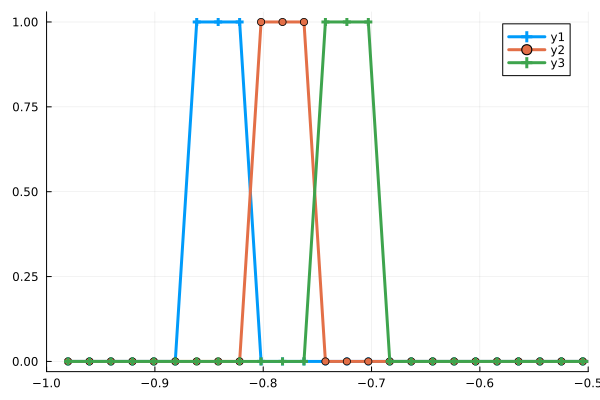

In [22]:
agg = 1 .+ (0:m-1) .÷ 3
mc = maximum(agg)
T = zeros(m, mc)
for (i, j) in enumerate(agg)
    T[i,j] = 1
end
plot(x, T[:, 3:5], marker=:auto, xlims=(-1, -.5))

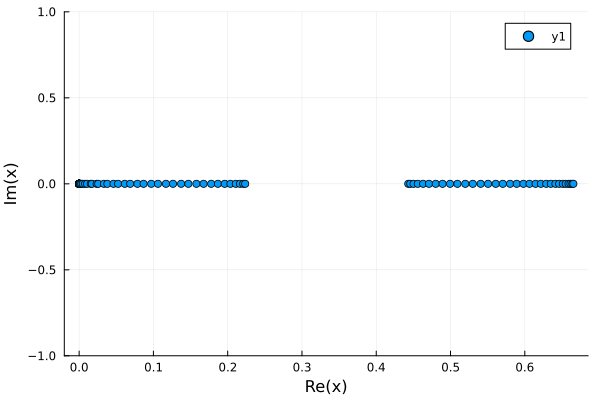

In [23]:
Sc = T * ((T' * A * T) \ T') * A
w = .67; k = 1
E = (I - w*A)^k * (I - Sc) * (I - w*A)^k
scatter(eigvals(E), ylims=(-1, 1))

* simple and cheap method
* stronger smoothing (bigger `k`) doesn't help much; need more accurate coarse grid

# Smoothed aggregation

$$ P = (I - w A) T $$

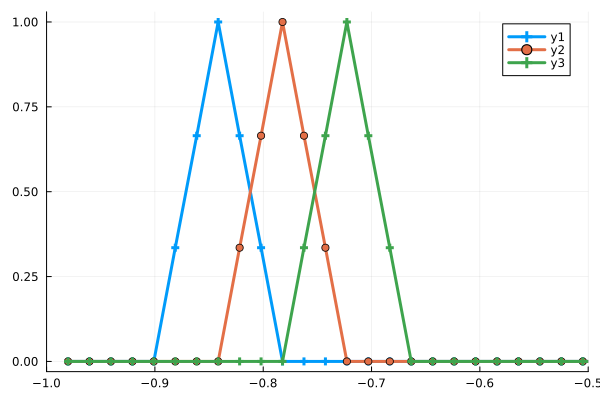

In [24]:
P = (I - w * A) * T
plot(x, P[:, 3:5], marker=:auto, xlims=(-1,-.5))

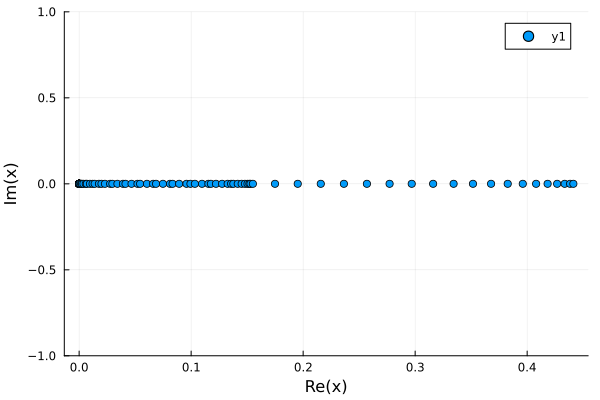

In [25]:
Sc = P * ((P' * A * P) \ P') * A
w = .67; k = 1
E = (I - w*A)^k * (I - Sc) * (I - w*A)^k
scatter(eigvals(E), ylims=(-1, 1))

* Eigenvalues are closer to zero; stronger smoothing (larger `k`) helps.
* Smoother can be made stronger using Chebyshev (like varying the damping between iterations in Jacobi)

# Multigrid in PETSc

## Geometric multigrid

* `-pc_type mg`
  * needs a grid hierarchy (automatic with `DM`)
  * `PCMGSetLevels()`
  * `PCMGSetInterpolation()`
  * `PCMGSetRestriction()`
* `-pc_mg_cycle_type [v,w]`
* `-mg_levels_ksp_type chebyshev`
* `-mg_levels_pc_type jacobi`
* `-mg_coarse_pc_type svd`
  * `-mg_coarse_pc_svd_monitor` (report singular values/diagnose singular coarse grids)

## Algebraic multigrid

* `-pc_type gamg`
  * native PETSc implementation of smoothed aggregation (and experimental stuff), all `-pc_type mg` options apply.
  * [`MatSetNearNullSpace()`](https://petsc.org/release/docs/manualpages/Mat/MatSetNearNullSpace/)
  * [`MatNullSpaceCreateRigidBody()`](https://petsc.org/release/docs/manualpages/Mat/MatNullSpaceCreateRigidBody/)
  * [`DMPlexCreateRigidBody()`](https://petsc.org/release/docs/manualpages/DMPlex/DMPlexCreateRigidBody/)
  * `-pc_gamg_threshold .01` drops weak edges in strength graph
* `-pc_type ml`
  * similar to `gamg` with different defaults
* `-pc_type hypre`
  * Classical AMG (based on C-F splitting)
  * Manages its own grid hierarchy